In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [4]:
!nvidia-smi

Sat Dec  7 10:34:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

In [6]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
device

device(type='cuda')

In [10]:
print('Device:', device)
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Count of using GPUs: 1


In [11]:
def display_images(image_paths, title, max_images=5):
    plt.figure(figsize=(12, 3))
    for i, image_path in enumerate(image_paths[5:max_images+5]):
        img = plt.imread(image_path)
        plt.subplot(1, max_images, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
    plt.show()

In [12]:
categories = ['Train calculus', 'Train caries', 'Train discoloration', 'Train hypodontia', 'Train ulcers',
              'Val calculus', 'Val caries', 'Val discoloration', 'Val hypodontia', 'Val ulcers',
              'Test calculus', 'Test caries', 'Test discoloration', 'Test hypodontia', 'Test ulcers']

for category in categories:
    image_paths = glob.glob(f'/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/{category.lower().replace(" ", "/")}/*')
    display_images(image_paths, category)
    print(f"{category} 총 이미지 수: {len(image_paths)}")

plt.figure(figsize=(10, 6))
plt.bar(categories, [len(glob.glob(f'/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/{category.lower().replace(" ", "/")}/*')) for category in categories], color=['blue', 'orange', 'green', 'red', 'black'])
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [13]:
!pip install imgaug

# Imgaug 활용 Augmentation

In [36]:
from imgaug import augmenters as iaa
import imgaug as ia

class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Sometimes(0.3, iaa.Affine(rotate=(-20, 20), mode='symmetric')),
            iaa.Sometimes(0.2, iaa.Multiply((0.8, 1.2))),
            iaa.Sometimes(0.1, iaa.CLAHE()),
            iaa.Sometimes(0.3, iaa.AdditiveGaussianNoise(scale=(0, 0.2*255))),
            iaa.Sometimes(0.3, iaa.GaussianBlur(sigma=(0, 3.0))),
            iaa.Sometimes(0.3, iaa.CropAndPad(percent=(-0.1, 0.1))),
            iaa.Sometimes(0.1, iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6))),
            iaa.Sometimes(0.1, iaa.MultiplySaturation((0.8, 1.2))),
        ])

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

In [43]:
class CustomDataset_Imgaug(ImageFolder):
    def __init__(self, root, imgaug=None, transform=None, sample_per_class=None):
        super(CustomDataset_Imgaug, self).__init__(root, transform=transform)
        self.imgaug_transform = imgaug

        if sample_per_class is not None:
            self.samples = self._reduce_samples(sample_per_class)

    def _reduce_samples(self, sample_per_class):
        class_samples = {}
        for path, target in self.samples:
            if target not in class_samples:
                class_samples[target] = [path]
            else:
                class_samples[target].append(path)

        reduced_samples = []
        for target, paths in class_samples.items():
            if len(paths) > sample_per_class:
                reduced_samples.extend([(path, target) for path in random.sample(paths, sample_per_class)])
            else:
                reduced_samples.extend([(path, target) for path in paths])


        return reduced_samples

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)

        if self.imgaug_transform is not None:
            img = self.imgaug_transform(img)
            img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [44]:
# PyTorch transforms에서 ToTensor 및 Normalize만 적용
from torchvision import transforms
pytorch_transforms = transforms.Compose([
    transforms.Resize((456, 456)),  # 이미지 크기 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [238]:

pytorch_transforms_224 = transforms.Compose([
    transforms.Resize((224, 224)),  # 이미지 크기 조정
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [45]:
train_dataset_Imgaug = CustomDataset_Imgaug('/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/train',
    imgaug=ImgAugTransform(),
    transform=pytorch_transforms
)

val_dataset_Imgaug = CustomDataset_Imgaug(
    '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/val',
    imgaug=None,
    transform=pytorch_transforms
)

train_loader_Imgaug = DataLoader(
    dataset=train_dataset_Imgaug,
    batch_size=8,
    shuffle=True
)

val_loader_Imgaug = DataLoader(
    dataset=val_dataset_Imgaug,
    batch_size=8,
    shuffle=False
)

In [59]:
def imshow_Imgaug(img, labels, class_to_idx, size=(20, 20), mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    img = img.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(img)
    plt.axis('off')


    rows = 2
    cols = 4
    for i, label in enumerate(labels[:8]):
        class_name = idx_to_class[label.item()]
        x = (i % cols) * (img.shape[1] // cols) + (img.shape[1] // cols) // 2
        y = (i // cols) * (img.shape[0] // rows) + (img.shape[0] // rows) // 2
        plt.text(x, y, f'{label.item()}, {class_name}', color='black', fontsize=14,
                 horizontalalignment='center', verticalalignment='center')

    plt.show()

In [60]:
dataiter = iter(train_loader_Imgaug)
images, label = next(dataiter)

class_to_idx = train_loader_Imgaug.dataset.class_to_idx

imshow_Imgaug(make_grid(images[:8], nrow=4), label, class_to_idx, size=(20, 10))

Output hidden; open in https://colab.research.google.com to view.

## Albumentations 활용 Augmentation

### Pytorch + 대규모 데이터셋에 빠른 성능, Tensor 변환 용이

orizontalFlip: 이미지의 좌우 반전  
Rotate: 회전  
RandomBrightnessContrast: 이미지의 밝기와 대비  
GaussNoise: Gaussian 노이즈  
CLAHE: 이미지의 대비를  
GaussianBlur: Gaussian 블러  
HueSaturationValue: 이미지의 색조와 채도를 조정  
ToTensorV2: 이미지를 PyTorch 텐서로 변환

In [191]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


transform_Album = A.Compose([
            A.Resize(height=256, width=256),  # 모든 이미지를 256x256으로 조정
            A.HorizontalFlip(p=0.5),  # 좌우 반전
            A.Rotate(limit=20, p=0.3),  # 회전
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),  # 밝기/대비 조정
            A.GaussNoise(var_limit=(0, 0.2 * 255), p=0.3),  # Gaussian 노이즈 추가
            A.CLAHE(p=0.1),  # CLAHE
            A.GaussianBlur(blur_limit=(0, 3.0), p=0.3),  # Gaussian Blur
            A.HueSaturationValue(sat_shift_limit=20, p=0.1),  # 채도 조정
            A.Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2()
        ])

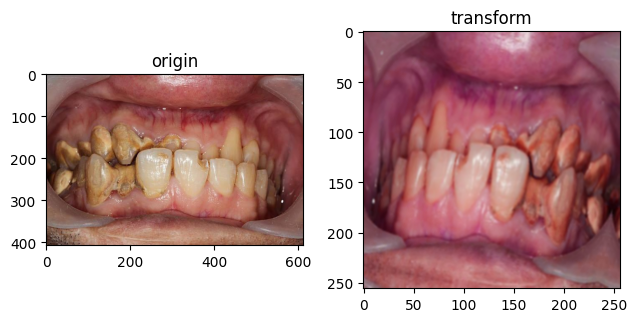

In [183]:
from albumentations.pytorch import ToTensorV2
from glob import glob
from PIL import Image
import random

data_root = '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/train'
filepath_list = list(glob(f"{data_root}/**/*.jpg"))
random.shuffle(filepath_list)

image_list = []
for idx in range(3):
    image_list.append(Image.open(filepath_list[idx]))

sample_image = image_list[0]

random.seed(42)

def visualize_images(image1, image2):

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(image1)
    axs[0].set_title('origin')

    axs[1].imshow(image2)
    axs[1].set_title('transform')

    plt.tight_layout()
    plt.show()

transformed_image = transform_Album(image=np.array(sample_image))['image']

visualize_images(sample_image, transformed_image)

In [234]:
import random
from torchvision.datasets import ImageFolder
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CustomDataset_Album(ImageFolder):
    def __init__(self, root, albumentations_transform=None, sample_per_class=None):
        super(CustomDataset_Album, self).__init__(root)
        self.albumentations_transform = albumentations_transform

        if sample_per_class is not None:
            self.samples = self._reduce_samples(sample_per_class)

    def _reduce_samples(self, sample_per_class):
        class_samples = {}
        for path, target in self.samples:
            if target not in class_samples:
                class_samples[target] = [path]
            else:
                class_samples[target].append(path)

        reduced_samples = []
        for target, paths in class_samples.items():
            if len(paths) > sample_per_class:
                reduced_samples.extend([(path, target) for path in random.sample(paths, sample_per_class)])
            else:
                reduced_samples.extend([(path, target) for path in paths])

        return reduced_samples

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)

        # Albumentations 변환 적용
        if self.albumentations_transform is not None:
            img = np.array(img)  # PIL 이미지를 NumPy 배열로 변환
            augmented = self.albumentations_transform(image=img)  # Albumentations 변환 적용
            img = augmented['image']  # 변환된 이미지를 텐서로 반환

        return img, target  # img는 텐서, target은 레이블

In [235]:

train_dataset_Album = CustomDataset_Album(
    '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/train',
    albumentations_transform=transform_Album
)

val_dataset_Album = CustomDataset_Album(
    '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/val',
    albumentations_transform=None
)

train_loader_Album = DataLoader(
    dataset=train_dataset_Album,
    batch_size=8,
    shuffle=True
)

val_loader_Album = DataLoader(
    dataset=val_dataset_Album,
    batch_size=8,
    shuffle=False
)

### Albumentation 시각화

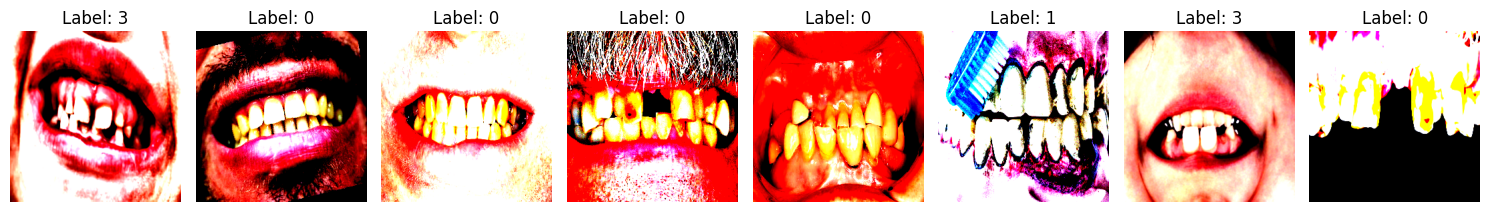

In [236]:
import matplotlib.pyplot as plt
import numpy as np
def visualize_images(loader, num_images=8):
    images, labels = next(iter(loader))

    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img = images[i].permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)로 변환
        img = np.clip(img, 0, 1)

        plt.subplot(2, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 시각화 호출
visualize_images(train_loader_Album, num_images=8)

# 모델 직접 구현 (VGGnet, ResNet, EfficientNet, ViT, SwinTransformer, ConvNeXt )

### VGGnet


In [1]:
cfgs = { "E": [64, 64, "M", 128, 128, "M", 256, 256, 256, 256, "M", 512, 512, 512, 512, "M", 512, 512, 512, 512, "M"] }

In [196]:
class VGG(nn.Module):
    def __init__(self, cfg, batch_norm, num_classes = 1000, init_weights = True, drop_p = 0.5):
        super().__init__()

        self.features = self.make_layers(cfg, batch_norm)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7)) # 7x7 이 되도록 avg pooling 하는 녀석
        self.classifier = nn.Sequential(nn.Linear(512 * 7 * 7, 4096),
                                        nn.ReLU(),
                                        nn.Dropout(p=drop_p),
                                        nn.Linear(4096, 4096),
                                        nn.ReLU(),
                                        nn.Dropout(p=drop_p),
                                        nn.Linear(4096, num_classes))

        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def make_layers(self, cfg, batch_norm = False):
        layers = []
        in_channels = 3
        for v in cfg: # cfg = [64, 64, "M", 128, 128, "M", 256, 256, 256, "M", 512, 512, 512, "M", 512, 512, 512, "M"]
            if type(v) == int:
                if batch_norm:
                    layers += [nn.Conv2d(in_channels, v, 3, padding=1), # 어차피 BN에 bias 포함
                               nn.BatchNorm2d(v),
                               nn.ReLU()]
                else:
                    layers += [nn.Conv2d(in_channels, v, 3, padding=1),
                               nn.ReLU()]
                in_channels = v
            else:
                layers += [nn.MaxPool2d(2)]

        return nn.Sequential(*layers)

### torch에 있는 기본 VGGNet, 마지막 노드 = 1000개 => 조정 필요

In [214]:
model_VGG_torch = VGG(cfgs["E"], batch_norm=True, num_classes = 5)
print(model_VGG_torch)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

### Hugging Face timm 라이브러리 활용 VGGNet 불러오기(num_classes로 마지막 노드 조정)

In [200]:
import timm

model_VGG_timm = timm.create_model("hf_hub:timm/vgg16.tv_in1k", pretrained=True, num_classes = 5)
print(model_VGG_timm)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/553M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [215]:
model_VGG_torch = model_VGG_torch.to(device)
model_VGG_timm = model_VGG_timm.to(device)

In [206]:
criterion = nn.CrossEntropyLoss()

### WandB로 딥러닝 프로젝트 모니터링

In [223]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 26.8 MB/s eta 0:00:00


In [224]:
import wandb
import random
import math
wandb.login()

wandb: Currently logged in as: datafullstack0514 (datafullstack0514-person). Use `wandb login --relogin` to force relogin


True

In [225]:
wandb.init(
    project="Dental_class")

In [227]:
def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    if optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    elif optimizer_name == 'Lion':
        optimizer = Lion(net.parameters(), lr=0.00003, betas=(0.9, 0.999), weight_decay=1e-2)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            wandb.log({"loss": loss})

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        correct = 0
        net.eval()
        total = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                probabilities = F.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        wandb.log({"train_loss": train_loss, "val_loss": val_loss, "val_accuracy": val_accuracy})

        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

In [230]:
train_losses_Imgaug_RAdam, val_losses_Imgaug_RAdam, val_accuracies_Imgaug_RAdam = train_model('RAdam', model_VGG_torch, train_loader_Imgaug, val_loader_Imgaug, criterion, num_epochs= 10)

Epoch 1/10: 100%|██████████| 69/69 [01:00<00:00,  1.13it/s]


[RAdam] Epoch 1, Train Loss: 1.251613, Val Loss: 0.989320, Validation Accuracy: 67.28%


Epoch 2/10: 100%|██████████| 69/69 [00:25<00:00,  2.76it/s]


[RAdam] Epoch 2, Train Loss: 1.053014, Val Loss: 0.802206, Validation Accuracy: 72.94%


Epoch 3/10: 100%|██████████| 69/69 [00:25<00:00,  2.76it/s]


[RAdam] Epoch 3, Train Loss: 0.943749, Val Loss: 0.810980, Validation Accuracy: 74.41%


Epoch 4/10: 100%|██████████| 69/69 [00:26<00:00,  2.56it/s]


[RAdam] Epoch 4, Train Loss: 0.822344, Val Loss: 1.025085, Validation Accuracy: 57.04%


Epoch 5/10: 100%|██████████| 69/69 [00:25<00:00,  2.75it/s]


[RAdam] Epoch 5, Train Loss: 0.747025, Val Loss: 0.746923, Validation Accuracy: 74.77%


Epoch 6/10: 100%|██████████| 69/69 [00:25<00:00,  2.76it/s]


[RAdam] Epoch 6, Train Loss: 0.694364, Val Loss: 0.736985, Validation Accuracy: 77.15%


Epoch 7/10: 100%|██████████| 69/69 [00:25<00:00,  2.73it/s]


[RAdam] Epoch 7, Train Loss: 0.640077, Val Loss: 1.084804, Validation Accuracy: 57.40%


Epoch 8/10: 100%|██████████| 69/69 [00:25<00:00,  2.75it/s]


[RAdam] Epoch 8, Train Loss: 0.600636, Val Loss: 0.787631, Validation Accuracy: 73.49%


Epoch 9/10: 100%|██████████| 69/69 [00:25<00:00,  2.75it/s]


[RAdam] Epoch 9, Train Loss: 0.607732, Val Loss: 1.065985, Validation Accuracy: 61.24%


Epoch 10/10: 100%|██████████| 69/69 [00:24<00:00,  2.76it/s]

[RAdam] Epoch 10, Train Loss: 0.586624, Val Loss: 0.633079, Validation Accuracy: 76.97%


### Aug : Albumention + Optimizer : lion

In [229]:
!pip install lion-pytorch

In [237]:
from lion_pytorch import Lion

train_losses_efficientnet, val_losses_efficientnet, val_accuracies_efficientnet = train_model('Lion', model_VGG_timm, train_loader_Album, val_loader_Album, criterion, num_epochs= 10)

Epoch 1/10:   0%|          | 0/69 [00:00<?, ?it/s]


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>

In [ ]:
efficientnet = models.efficientnet_b5(pretrained=True)

for param in efficientnet.parameters():
    param.requires_grad = False

efficientnet.classifier[1] = nn.Linear(2048, 5)
# efficientnet.classifier[1].requires_grad = True

for param in efficientnet.classifier.parameters():
    param.requires_grad = True

efficientnet = efficientnet.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:00<00:00, 154MB/s] 


In [ ]:

criterion = nn.CrossEntropyLoss()

In [ ]:
base_optimizer = torch.optim.AdamW

In [ ]:
def train_model(optimizer_name, net, train_loader, val_loader, criterion, num_epochs=20):
    if optimizer_name == 'RAdam':
        optimizer = optim.RAdam(net.parameters(), lr=0.00003, betas=(0.9, 0.999))
    elif optimizer_name == 'Lion':
        optimizer = Lion(net.parameters(), lr=0.00003, betas=(0.9, 0.999), weight_decay=1e-2)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        net.train()
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        correct = 0
        net.eval()
        total = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                probabilities = F.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f'[{optimizer_name}] Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, val_accuracies

### EfficientNet 학습

In [ ]:
train_losses_efficientnet, val_losses_efficientnet, val_accuracies_efficientnet = train_model('RAdam', efficientnet, train_loader, val_loader, criterion)

Epoch 1/50: 100%|██████████| 69/69 [02:52<00:00,  2.50s/it]


[RAdam] Epoch 1, Train Loss: 1.515441, Val Loss: 1.572105, Validation Accuracy: 31.81%


Epoch 2/50: 100%|██████████| 69/69 [02:19<00:00,  2.02s/it]


[RAdam] Epoch 2, Train Loss: 1.432755, Val Loss: 1.537933, Validation Accuracy: 38.57%


Epoch 3/50: 100%|██████████| 69/69 [02:18<00:00,  2.00s/it]


[RAdam] Epoch 3, Train Loss: 1.340877, Val Loss: 1.495974, Validation Accuracy: 47.35%


Epoch 4/50: 100%|██████████| 69/69 [02:19<00:00,  2.02s/it]


[RAdam] Epoch 4, Train Loss: 1.274518, Val Loss: 1.452431, Validation Accuracy: 52.29%


Epoch 5/50: 100%|██████████| 69/69 [02:18<00:00,  2.01s/it]


[RAdam] Epoch 5, Train Loss: 1.219387, Val Loss: 1.419926, Validation Accuracy: 54.48%


Epoch 6/50: 100%|██████████| 69/69 [02:18<00:00,  2.00s/it]


[RAdam] Epoch 6, Train Loss: 1.181257, Val Loss: 1.383937, Validation Accuracy: 57.59%


Epoch 7/50: 100%|██████████| 69/69 [02:18<00:00,  2.01s/it]


[RAdam] Epoch 7, Train Loss: 1.128043, Val Loss: 1.344623, Validation Accuracy: 59.41%


Epoch 8/50: 100%|██████████| 69/69 [02:18<00:00,  2.01s/it]


[RAdam] Epoch 8, Train Loss: 1.090080, Val Loss: 1.305983, Validation Accuracy: 62.34%


Epoch 9/50: 100%|██████████| 69/69 [02:20<00:00,  2.04s/it]


[RAdam] Epoch 9, Train Loss: 1.072397, Val Loss: 1.281899, Validation Accuracy: 63.07%


Epoch 10/50: 100%|██████████| 69/69 [02:21<00:00,  2.05s/it]


[RAdam] Epoch 10, Train Loss: 1.036805, Val Loss: 1.242937, Validation Accuracy: 65.81%


Epoch 11/50: 100%|██████████| 69/69 [02:19<00:00,  2.03s/it]


[RAdam] Epoch 11, Train Loss: 0.999715, Val Loss: 1.216667, Validation Accuracy: 66.91%


Epoch 12/50: 100%|██████████| 69/69 [02:23<00:00,  2.07s/it]


[RAdam] Epoch 12, Train Loss: 0.974844, Val Loss: 1.200304, Validation Accuracy: 67.82%


Epoch 13/50: 100%|██████████| 69/69 [02:23<00:00,  2.08s/it]


[RAdam] Epoch 13, Train Loss: 0.957219, Val Loss: 1.163316, Validation Accuracy: 68.92%


Epoch 14/50: 100%|██████████| 69/69 [02:22<00:00,  2.06s/it]


[RAdam] Epoch 14, Train Loss: 0.933537, Val Loss: 1.139125, Validation Accuracy: 70.38%


Epoch 15/50: 100%|██████████| 69/69 [02:29<00:00,  2.17s/it]


[RAdam] Epoch 15, Train Loss: 0.931042, Val Loss: 1.119934, Validation Accuracy: 71.12%


Epoch 16/50: 100%|██████████| 69/69 [02:20<00:00,  2.04s/it]


[RAdam] Epoch 16, Train Loss: 0.904753, Val Loss: 1.100192, Validation Accuracy: 72.03%


Epoch 17/50: 100%|██████████| 69/69 [02:19<00:00,  2.02s/it]


[RAdam] Epoch 17, Train Loss: 0.892068, Val Loss: 1.091194, Validation Accuracy: 71.30%


Epoch 18/50: 100%|██████████| 69/69 [02:22<00:00,  2.06s/it]


[RAdam] Epoch 18, Train Loss: 0.876267, Val Loss: 1.061791, Validation Accuracy: 72.76%


Epoch 19/50: 100%|██████████| 69/69 [02:21<00:00,  2.05s/it]


[RAdam] Epoch 19, Train Loss: 0.862811, Val Loss: 1.047565, Validation Accuracy: 73.49%


Epoch 20/50: 100%|██████████| 69/69 [02:23<00:00,  2.07s/it]


[RAdam] Epoch 20, Train Loss: 0.842935, Val Loss: 1.045455, Validation Accuracy: 73.49%


Epoch 21/50: 100%|██████████| 69/69 [02:23<00:00,  2.08s/it]


[RAdam] Epoch 21, Train Loss: 0.839032, Val Loss: 1.027281, Validation Accuracy: 73.86%


Epoch 22/50: 100%|██████████| 69/69 [02:22<00:00,  2.07s/it]


[RAdam] Epoch 22, Train Loss: 0.838838, Val Loss: 1.001520, Validation Accuracy: 75.32%


Epoch 23/50: 100%|██████████| 69/69 [02:22<00:00,  2.06s/it]


[RAdam] Epoch 23, Train Loss: 0.822689, Val Loss: 0.988829, Validation Accuracy: 75.32%


Epoch 24/50: 100%|██████████| 69/69 [02:22<00:00,  2.06s/it]


[RAdam] Epoch 24, Train Loss: 0.807311, Val Loss: 0.983956, Validation Accuracy: 76.05%


Epoch 25/50: 100%|██████████| 69/69 [02:23<00:00,  2.08s/it]


[RAdam] Epoch 25, Train Loss: 0.804460, Val Loss: 0.976581, Validation Accuracy: 76.42%


Epoch 26/50: 100%|██████████| 69/69 [02:22<00:00,  2.06s/it]


[RAdam] Epoch 26, Train Loss: 0.791052, Val Loss: 0.959110, Validation Accuracy: 74.95%


Epoch 27/50: 100%|██████████| 69/69 [02:23<00:00,  2.08s/it]


[RAdam] Epoch 27, Train Loss: 0.772227, Val Loss: 0.955369, Validation Accuracy: 75.14%


Epoch 28/50: 100%|██████████| 69/69 [02:22<00:00,  2.06s/it]


[RAdam] Epoch 28, Train Loss: 0.762475, Val Loss: 0.937264, Validation Accuracy: 76.42%


Epoch 29/50: 100%|██████████| 69/69 [02:24<00:00,  2.09s/it]


[RAdam] Epoch 29, Train Loss: 0.786518, Val Loss: 0.938479, Validation Accuracy: 74.59%


Epoch 30/50: 100%|██████████| 69/69 [02:23<00:00,  2.08s/it]


[RAdam] Epoch 30, Train Loss: 0.759503, Val Loss: 0.921232, Validation Accuracy: 76.78%


Epoch 31/50: 100%|██████████| 69/69 [02:23<00:00,  2.08s/it]


[RAdam] Epoch 31, Train Loss: 0.755082, Val Loss: 0.916429, Validation Accuracy: 75.69%


Epoch 32/50: 100%|██████████| 69/69 [02:24<00:00,  2.09s/it]


[RAdam] Epoch 32, Train Loss: 0.741106, Val Loss: 0.906825, Validation Accuracy: 75.50%


Epoch 33/50: 100%|██████████| 69/69 [02:24<00:00,  2.09s/it]


[RAdam] Epoch 33, Train Loss: 0.743014, Val Loss: 0.902994, Validation Accuracy: 75.69%


Epoch 34/50: 100%|██████████| 69/69 [02:24<00:00,  2.10s/it]


[RAdam] Epoch 34, Train Loss: 0.731785, Val Loss: 0.889973, Validation Accuracy: 75.87%


Epoch 35/50: 100%|██████████| 69/69 [02:24<00:00,  2.10s/it]


[RAdam] Epoch 35, Train Loss: 0.737087, Val Loss: 0.891942, Validation Accuracy: 75.50%


Epoch 36/50: 100%|██████████| 69/69 [02:24<00:00,  2.09s/it]


[RAdam] Epoch 36, Train Loss: 0.747512, Val Loss: 0.890593, Validation Accuracy: 75.69%


Epoch 37/50: 100%|██████████| 69/69 [02:21<00:00,  2.06s/it]


[RAdam] Epoch 37, Train Loss: 0.729631, Val Loss: 0.870773, Validation Accuracy: 75.87%


Epoch 38/50: 100%|██████████| 69/69 [02:26<00:00,  2.12s/it]


[RAdam] Epoch 38, Train Loss: 0.725081, Val Loss: 0.868328, Validation Accuracy: 75.50%


Epoch 39/50: 100%|██████████| 69/69 [02:21<00:00,  2.06s/it]


[RAdam] Epoch 39, Train Loss: 0.707183, Val Loss: 0.858590, Validation Accuracy: 76.23%


Epoch 40/50: 100%|██████████| 69/69 [02:21<00:00,  2.06s/it]


[RAdam] Epoch 40, Train Loss: 0.726559, Val Loss: 0.858562, Validation Accuracy: 76.05%


Epoch 41/50: 100%|██████████| 69/69 [02:22<00:00,  2.06s/it]


[RAdam] Epoch 41, Train Loss: 0.678031, Val Loss: 0.851309, Validation Accuracy: 76.23%


Epoch 42/50:   6%|▌         | 17/302 [00:37<10:09,  2.14s/it]

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(train_losses_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(val_losses_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(val_accuracies_efficientnet, label='efficientnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)

In [ ]:
class_folders = {
    'calculus': '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/test/calculus',
    'caries': '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/test/caries',
    'discoloration': '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/test/discoloration',
    'hypodontia': '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/test/hypodontia',
    'ulcers': '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/test/ulcers'
}

idx_to_class = {idx: class_name for idx, class_name in enumerate(class_folders.keys())}

plt.figure(figsize=(20, 8))
counter = 1

for class_name, folder_path in class_folders.items():
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]

    for image_path in selected_paths:
        if counter > 10:
            break

        image = load_and_transform_image(image_path, pytorch_transforms)
        efficientnet.eval()
        with torch.no_grad():
            outputs = efficientnet(image)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(probabilities, 1)
        prediction = idx_to_class[predicted.item()]

        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1

        if counter > 10:
            break

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, class_folders, transform, target_class):
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    class_to_idx = {'calculus': 0, 'caries': 1, 'discoloration': 2, 'hypodontia': 3, 'ulcers': 4}


    for class_name, folder_path in class_folders.items():
        image_paths = glob.glob(os.path.join(folder_path, '*'))

        for image_path in image_paths:
            image = load_and_transform_image(image_path, transform)

            with torch.no_grad():
                outputs = model(image)
                probabilities = F.softmax(outputs, dim=1)
                _, predicted = torch.max(probabilities, 1)
                prediction = predicted.item()
                all_preds.append(prediction)
                all_labels.append(class_to_idx[class_name])

    target_preds = [1 if pred == class_to_idx[target_class] else 0 for pred in all_preds]
    target_labels = [1 if label == class_to_idx[target_class] else 0 for label in all_labels]

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(target_labels, target_preds, average='weighted')
    recall = recall_score(target_labels, target_preds, average='weighted')
    f1 = f1_score(target_labels, target_preds, average='weighted')

    return accuracy, precision, recall, f1

In [ ]:
for class_name in class_folders.keys():
    metrics = evaluate_model(efficientnet, class_folders, pytorch_transforms, class_name)
    print(f"{class_name.capitalize()} Metrics: Accuracy: {metrics[0]:.4f}, Precision: {metrics[1]:.4f}, Recall: {metrics[2]:.4f}, F1: {metrics[3]:.4f}")

In [241]:
train_dataset_Imgaug_224 = CustomDataset_Imgaug('/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/train',
    imgaug=ImgAugTransform(),
    transform=pytorch_transforms_224
)

val_dataset_Imgaug_224 = CustomDataset_Imgaug(
    '/content/drive/Othercomputers/내 Mac/Image_DL_Fastcampus/Part 2/Chapter 1 ~ Chapter 15/6/val',
    imgaug=None,
    transform=pytorch_transforms_224
)

train_loader_Imgaug_224 = DataLoader(
    dataset=train_dataset_Imgaug_224,
    batch_size=8,
    shuffle=True
)

val_loader_Imgaug_224 = DataLoader(
    dataset=val_dataset_Imgaug_224,
    batch_size=8,
    shuffle=False
)

In [242]:
from transformers import ViTForImageClassification, ViTImageProcessor
ViT = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", attn_implementation="sdpa", torch_dtype=torch.float16)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')




train_losses_ViT, val_losses_ViT, val_accuracies_ViT = train_model('Lion', ViT, train_loader_Imgaug_224, val_loader_Imgaug_224, criterion, num_epochs=20)

Epoch 1/20:   0%|          | 0/302 [00:00<?, ?it/s]


RuntimeError: Input type (torch.cuda.HalfTensor) and weight type (torch.HalfTensor) should be the same